# **Fine-Tuning a Pre-trained Model for Multilingual Sentence Pair Classification**

### **Step 1: Import Required Libraries**

Import necessary libraries for data handling, model setup, and training.

In [1]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

/home/yazata/venvs/ai_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-12 16:33:12.876705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736695992.906895  108100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736695992.912839  108100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 16:33:12.943144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical op

### **Step 2: Load and prepare the Dataset**

Load the raw unbalanced data and split it into train, validation, and test sets.

In [3]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the raw dataset
data = pd.read_csv("../data/train.csv")
data = data.dropna(subset=["premise", "hypothesis"])  # Drop missing entries

# Display language distribution for reference
language_counts = data["language"].value_counts()
print("Language distribution in the dataset:")
print(language_counts)

# Split the dataset (80% train, 10% validation, 10% test)
train_data, test_data = train_test_split(
    data, test_size=0.1, stratify=data["language"], random_state=123
)
train_data, val_data = train_test_split(
    train_data, test_size=0.2, stratify=train_data["language"], random_state=123
)

# Convert splits to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Combine splits into a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

Language distribution in the dataset:
language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: count, dtype: int64


### **Step 3: Tokenize the Dataset**

Preprocess the dataset for the model.

In [4]:
# Specify model and load tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def preprocess_function(examples):
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(["premise", "hypothesis", "language", "lang_abv"])
print("Tokenized dataset prepared.")

Map: 100%|██████████| 1212/1212 [00:00<00:00, 7168.74 examples/s]

Tokenized dataset prepared.


### **Step 4: Define the Model and Training Arguments**

Set up the model and configure the training process.

In [6]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3  # Number of classes: entailment, neutral, contradiction
)
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./results_{model_name.replace('/', '_')}",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=f"./logs_{model_name.replace('/', '_')}",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Step 5: Define Evaluation Metrics**

Define the metrics to evaluate the model during training and testing.

In [8]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

### **Step 6: Train and Evaluate the Model**

Initialize the trainer, train the model, and evaluate it.

In [9]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_dataset["test"])
print(f"Test Results: {test_results}")

/tmp/ipykernel_108100/4245397266.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▏         | 100/5460 [00:52<46:41,  1.91it/s]

{'loss': 1.1036, 'grad_norm': 4.320657730102539, 'learning_rate': 1.9633699633699634e-05, 'epoch': 0.18}


  4%|▎         | 200/5460 [01:44<45:57,  1.91it/s]

{'loss': 1.1015, 'grad_norm': 2.932884454727173, 'learning_rate': 1.926739926739927e-05, 'epoch': 0.37}


  5%|▌         | 300/5460 [02:37<45:40,  1.88it/s]

{'loss': 1.0996, 'grad_norm': 6.798247814178467, 'learning_rate': 1.8901098901098903e-05, 'epoch': 0.55}


  7%|▋         | 400/5460 [03:30<44:45,  1.88it/s]

{'loss': 1.0657, 'grad_norm': 13.167245864868164, 'learning_rate': 1.8534798534798536e-05, 'epoch': 0.73}


  9%|▉         | 500/5460 [04:22<43:18,  1.91it/s]

{'loss': 1.031, 'grad_norm': 11.843594551086426, 'learning_rate': 1.816849816849817e-05, 'epoch': 0.92}


                                                  
 10%|█         | 546/5460 [05:06<37:34,  2.18it/s]

{'eval_loss': 0.980492115020752, 'eval_accuracy': 0.5366636113657195, 'eval_f1': 0.5367072008890644, 'eval_runtime': 19.7783, 'eval_samples_per_second': 110.323, 'eval_steps_per_second': 6.927, 'epoch': 1.0}


 11%|█         | 600/5460 [05:44<40:40,  1.99it/s]   

{'loss': 0.9982, 'grad_norm': 14.71964168548584, 'learning_rate': 1.78021978021978e-05, 'epoch': 1.1}


 13%|█▎        | 700/5460 [06:34<39:48,  1.99it/s]

{'loss': 0.9264, 'grad_norm': 12.244475364685059, 'learning_rate': 1.7435897435897438e-05, 'epoch': 1.28}


 15%|█▍        | 800/5460 [07:24<39:01,  1.99it/s]

{'loss': 0.8743, 'grad_norm': 17.767852783203125, 'learning_rate': 1.706959706959707e-05, 'epoch': 1.47}


 16%|█▋        | 900/5460 [08:15<38:19,  1.98it/s]

{'loss': 0.8862, 'grad_norm': 11.711114883422852, 'learning_rate': 1.6703296703296707e-05, 'epoch': 1.65}


 18%|█▊        | 1000/5460 [09:05<37:20,  1.99it/s]

{'loss': 0.8381, 'grad_norm': 25.75884246826172, 'learning_rate': 1.633699633699634e-05, 'epoch': 1.83}


                                                   
 20%|██        | 1092/5460 [10:10<31:46,  2.29it/s]

{'eval_loss': 0.7613685727119446, 'eval_accuracy': 0.6805682859761687, 'eval_f1': 0.6797189785885362, 'eval_runtime': 18.7035, 'eval_samples_per_second': 116.663, 'eval_steps_per_second': 7.325, 'epoch': 2.0}


 20%|██        | 1100/5460 [10:18<1:17:54,  1.07s/it]

{'loss': 0.7726, 'grad_norm': 17.49947166442871, 'learning_rate': 1.5970695970695972e-05, 'epoch': 2.01}


 22%|██▏       | 1200/5460 [11:08<35:39,  1.99it/s]  

{'loss': 0.6772, 'grad_norm': 20.585647583007812, 'learning_rate': 1.5604395604395605e-05, 'epoch': 2.2}


 24%|██▍       | 1300/5460 [11:59<34:50,  1.99it/s]

{'loss': 0.6825, 'grad_norm': 19.544065475463867, 'learning_rate': 1.523809523809524e-05, 'epoch': 2.38}


 26%|██▌       | 1400/5460 [12:49<34:05,  1.98it/s]

{'loss': 0.6495, 'grad_norm': 22.746307373046875, 'learning_rate': 1.4871794871794874e-05, 'epoch': 2.56}


 27%|██▋       | 1500/5460 [13:39<33:12,  1.99it/s]

{'loss': 0.6416, 'grad_norm': 23.175752639770508, 'learning_rate': 1.4505494505494506e-05, 'epoch': 2.75}


 29%|██▉       | 1600/5460 [14:30<32:17,  1.99it/s]

{'loss': 0.67, 'grad_norm': 23.75398063659668, 'learning_rate': 1.4139194139194141e-05, 'epoch': 2.93}


                                                   
 30%|███       | 1638/5460 [15:07<27:46,  2.29it/s]

{'eval_loss': 0.6994487047195435, 'eval_accuracy': 0.7094408799266728, 'eval_f1': 0.7104367006044118, 'eval_runtime': 18.715, 'eval_samples_per_second': 116.591, 'eval_steps_per_second': 7.32, 'epoch': 3.0}


 31%|███       | 1700/5460 [15:43<31:45,  1.97it/s]  

{'loss': 0.5345, 'grad_norm': 18.636184692382812, 'learning_rate': 1.3772893772893774e-05, 'epoch': 3.11}


 33%|███▎      | 1800/5460 [16:35<31:54,  1.91it/s]

{'loss': 0.4833, 'grad_norm': 30.167104721069336, 'learning_rate': 1.3406593406593406e-05, 'epoch': 3.3}


 35%|███▍      | 1900/5460 [17:27<31:17,  1.90it/s]

{'loss': 0.4984, 'grad_norm': 27.380029678344727, 'learning_rate': 1.3040293040293041e-05, 'epoch': 3.48}


 37%|███▋      | 2000/5460 [18:20<30:24,  1.90it/s]

{'loss': 0.4872, 'grad_norm': 37.687400817871094, 'learning_rate': 1.2673992673992674e-05, 'epoch': 3.66}


 38%|███▊      | 2100/5460 [19:12<29:28,  1.90it/s]

{'loss': 0.523, 'grad_norm': 33.277557373046875, 'learning_rate': 1.230769230769231e-05, 'epoch': 3.85}


                                                   
 40%|████      | 2184/5460 [20:16<24:52,  2.19it/s]

{'eval_loss': 0.7713404893875122, 'eval_accuracy': 0.7131072410632447, 'eval_f1': 0.711709319149108, 'eval_runtime': 19.6904, 'eval_samples_per_second': 110.815, 'eval_steps_per_second': 6.958, 'epoch': 4.0}


 40%|████      | 2200/5460 [20:34<30:50,  1.76it/s]  

{'loss': 0.4572, 'grad_norm': 16.4804630279541, 'learning_rate': 1.1941391941391942e-05, 'epoch': 4.03}


 42%|████▏     | 2300/5460 [21:26<26:29,  1.99it/s]

{'loss': 0.3585, 'grad_norm': 12.715658187866211, 'learning_rate': 1.1575091575091577e-05, 'epoch': 4.21}


 44%|████▍     | 2400/5460 [22:16<25:40,  1.99it/s]

{'loss': 0.3482, 'grad_norm': 43.499900817871094, 'learning_rate': 1.120879120879121e-05, 'epoch': 4.4}


 46%|████▌     | 2500/5460 [23:06<24:51,  1.98it/s]

{'loss': 0.3974, 'grad_norm': 76.82129669189453, 'learning_rate': 1.0842490842490842e-05, 'epoch': 4.58}


 48%|████▊     | 2600/5460 [23:56<23:55,  1.99it/s]

{'loss': 0.3895, 'grad_norm': 49.015567779541016, 'learning_rate': 1.0476190476190477e-05, 'epoch': 4.76}


 49%|████▉     | 2700/5460 [24:47<23:05,  1.99it/s]

{'loss': 0.3545, 'grad_norm': 28.707883834838867, 'learning_rate': 1.010989010989011e-05, 'epoch': 4.95}


                                                   
 50%|█████     | 2730/5460 [25:20<19:49,  2.30it/s]

{'eval_loss': 0.7798226475715637, 'eval_accuracy': 0.7282309807516041, 'eval_f1': 0.7269773370388236, 'eval_runtime': 18.7071, 'eval_samples_per_second': 116.64, 'eval_steps_per_second': 7.323, 'epoch': 5.0}


 51%|█████▏    | 2800/5460 [26:00<22:18,  1.99it/s]  

{'loss': 0.3047, 'grad_norm': 34.77347183227539, 'learning_rate': 9.743589743589744e-06, 'epoch': 5.13}


 53%|█████▎    | 2900/5460 [26:50<21:26,  1.99it/s]

{'loss': 0.2882, 'grad_norm': 46.29841232299805, 'learning_rate': 9.377289377289379e-06, 'epoch': 5.31}


 55%|█████▍    | 3000/5460 [27:40<20:36,  1.99it/s]

{'loss': 0.2589, 'grad_norm': 56.74592208862305, 'learning_rate': 9.010989010989011e-06, 'epoch': 5.49}


 57%|█████▋    | 3100/5460 [28:31<19:46,  1.99it/s]

{'loss': 0.2674, 'grad_norm': 58.13346862792969, 'learning_rate': 8.644688644688646e-06, 'epoch': 5.68}


 59%|█████▊    | 3200/5460 [29:21<18:57,  1.99it/s]

{'loss': 0.3164, 'grad_norm': 57.7432975769043, 'learning_rate': 8.278388278388278e-06, 'epoch': 5.86}


                                                   
 60%|██████    | 3276/5460 [30:17<15:52,  2.29it/s]

{'eval_loss': 0.9892457127571106, 'eval_accuracy': 0.7199816681943172, 'eval_f1': 0.7214860469961158, 'eval_runtime': 18.7016, 'eval_samples_per_second': 116.674, 'eval_steps_per_second': 7.326, 'epoch': 6.0}


 60%|██████    | 3300/5460 [30:35<18:13,  1.98it/s]  

{'loss': 0.2319, 'grad_norm': 14.819436073303223, 'learning_rate': 7.912087912087913e-06, 'epoch': 6.04}


 62%|██████▏   | 3400/5460 [31:25<17:17,  1.99it/s]

{'loss': 0.214, 'grad_norm': 52.219058990478516, 'learning_rate': 7.5457875457875465e-06, 'epoch': 6.23}


 64%|██████▍   | 3500/5460 [32:15<16:28,  1.98it/s]

{'loss': 0.2496, 'grad_norm': 20.994518280029297, 'learning_rate': 7.17948717948718e-06, 'epoch': 6.41}


 66%|██████▌   | 3600/5460 [33:05<15:35,  1.99it/s]

{'loss': 0.24, 'grad_norm': 20.665557861328125, 'learning_rate': 6.813186813186814e-06, 'epoch': 6.59}


 68%|██████▊   | 3700/5460 [33:56<14:46,  1.99it/s]

{'loss': 0.2402, 'grad_norm': 25.82880973815918, 'learning_rate': 6.446886446886448e-06, 'epoch': 6.78}


 70%|██████▉   | 3800/5460 [34:46<13:55,  1.99it/s]

{'loss': 0.2278, 'grad_norm': 25.376262664794922, 'learning_rate': 6.080586080586081e-06, 'epoch': 6.96}


                                                   
 70%|███████   | 3822/5460 [35:15<11:53,  2.30it/s]

{'eval_loss': 1.328443169593811, 'eval_accuracy': 0.7140238313473877, 'eval_f1': 0.7143558279681883, 'eval_runtime': 18.6849, 'eval_samples_per_second': 116.779, 'eval_steps_per_second': 7.332, 'epoch': 7.0}


 71%|███████▏  | 3900/5460 [36:00<13:03,  1.99it/s]  

{'loss': 0.171, 'grad_norm': 137.36624145507812, 'learning_rate': 5.7142857142857145e-06, 'epoch': 7.14}


 73%|███████▎  | 4000/5460 [36:50<12:12,  1.99it/s]

{'loss': 0.1923, 'grad_norm': 38.70780563354492, 'learning_rate': 5.347985347985348e-06, 'epoch': 7.33}


 75%|███████▌  | 4100/5460 [37:40<11:23,  1.99it/s]

{'loss': 0.1271, 'grad_norm': 0.13180585205554962, 'learning_rate': 4.9816849816849826e-06, 'epoch': 7.51}


 77%|███████▋  | 4200/5460 [38:31<10:32,  1.99it/s]

{'loss': 0.19, 'grad_norm': 16.920944213867188, 'learning_rate': 4.615384615384616e-06, 'epoch': 7.69}


 79%|███████▉  | 4300/5460 [39:22<10:13,  1.89it/s]

{'loss': 0.165, 'grad_norm': 21.13184928894043, 'learning_rate': 4.249084249084249e-06, 'epoch': 7.88}


                                                   
 80%|████████  | 4368/5460 [40:18<08:22,  2.17it/s]

{'eval_loss': 1.5133241415023804, 'eval_accuracy': 0.7222731439046746, 'eval_f1': 0.7222632568595642, 'eval_runtime': 19.8908, 'eval_samples_per_second': 109.699, 'eval_steps_per_second': 6.888, 'epoch': 8.0}


 81%|████████  | 4400/5460 [40:44<09:20,  1.89it/s]  

{'loss': 0.1702, 'grad_norm': 102.00959777832031, 'learning_rate': 3.882783882783883e-06, 'epoch': 8.06}


 82%|████████▏ | 4500/5460 [41:37<08:11,  1.95it/s]

{'loss': 0.1481, 'grad_norm': 121.95063018798828, 'learning_rate': 3.516483516483517e-06, 'epoch': 8.24}


 84%|████████▍ | 4600/5460 [42:29<07:34,  1.89it/s]

{'loss': 0.1291, 'grad_norm': 6.089419841766357, 'learning_rate': 3.1501831501831505e-06, 'epoch': 8.42}


 86%|████████▌ | 4700/5460 [43:22<06:40,  1.90it/s]

{'loss': 0.1641, 'grad_norm': 17.995771408081055, 'learning_rate': 2.783882783882784e-06, 'epoch': 8.61}


 88%|████████▊ | 4800/5460 [44:15<05:48,  1.89it/s]

{'loss': 0.1299, 'grad_norm': 63.67506790161133, 'learning_rate': 2.4175824175824177e-06, 'epoch': 8.79}


 90%|████████▉ | 4900/5460 [45:08<04:52,  1.91it/s]

{'loss': 0.1459, 'grad_norm': 0.7733222246170044, 'learning_rate': 2.0512820512820513e-06, 'epoch': 8.97}


                                                   
 90%|█████████ | 4914/5460 [45:35<04:09,  2.19it/s]

{'eval_loss': 1.6474300622940063, 'eval_accuracy': 0.7080659945004583, 'eval_f1': 0.7089254621694379, 'eval_runtime': 20.2744, 'eval_samples_per_second': 107.624, 'eval_steps_per_second': 6.757, 'epoch': 9.0}


 92%|█████████▏| 5000/5460 [46:31<04:02,  1.90it/s]  

{'loss': 0.1024, 'grad_norm': 136.0276641845703, 'learning_rate': 1.6849816849816852e-06, 'epoch': 9.16}


 93%|█████████▎| 5100/5460 [47:24<03:11,  1.88it/s]

{'loss': 0.1473, 'grad_norm': 7.418491363525391, 'learning_rate': 1.3186813186813187e-06, 'epoch': 9.34}


 95%|█████████▌| 5200/5460 [48:17<02:17,  1.89it/s]

{'loss': 0.0893, 'grad_norm': 0.6974685192108154, 'learning_rate': 9.523809523809525e-07, 'epoch': 9.52}


 97%|█████████▋| 5300/5460 [49:10<01:25,  1.88it/s]

{'loss': 0.111, 'grad_norm': 75.84937286376953, 'learning_rate': 5.860805860805862e-07, 'epoch': 9.71}


 99%|█████████▉| 5400/5460 [50:03<00:31,  1.89it/s]

{'loss': 0.1316, 'grad_norm': 0.14022913575172424, 'learning_rate': 2.197802197802198e-07, 'epoch': 9.89}


                                                   
100%|██████████| 5460/5460 [51:03<00:00,  2.20it/s]

{'eval_loss': 1.690303921699524, 'eval_accuracy': 0.7153987167736022, 'eval_f1': 0.7160515910365707, 'eval_runtime': 19.6885, 'eval_samples_per_second': 110.826, 'eval_steps_per_second': 6.958, 'epoch': 10.0}


100%|██████████| 5460/5460 [51:14<00:00,  1.78it/s]


{'train_runtime': 3074.8904, 'train_samples_per_second': 28.378, 'train_steps_per_second': 1.776, 'train_loss': 0.4407314502275907, 'epoch': 10.0}


100%|██████████| 76/76 [00:10<00:00,  7.05it/s]

Test Results: {'eval_loss': 0.8486972451210022, 'eval_accuracy': 0.7046204620462047, 'eval_f1': 0.703000748648539, 'eval_runtime': 10.9111, 'eval_samples_per_second': 111.08, 'eval_steps_per_second': 6.965, 'epoch': 10.0}


### **Step 7: Save the Fine-Tuned Model**

Save the fine-tuned model and tokenizer.

In [12]:
# Save the fine-tuned model and tokenizer
output_dir = f"./fine_tuned_{model_name.replace('/', '_')}"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Fine-tuned model saved to {output_dir}")

Fine-tuned model saved to ./fine_tuned_xlm-roberta-base


### **Step 8: Analyze Results**

Save the results and plot performance.

Results saved to fine_tuning_results.csv


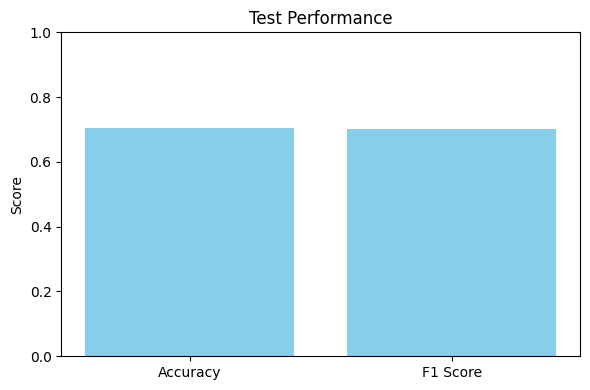

In [13]:
# Save results to a CSV file
results = [{"model": model_name, "accuracy": test_results["eval_accuracy"], "f1": test_results["eval_f1"]}]
results_df = pd.DataFrame(results)
results_filename = "fine_tuning_results.csv"
results_df.to_csv(results_filename, index=False)
print(f"Results saved to {results_filename}")

# Plot test accuracy and F1 score
plt.figure(figsize=(6, 4))
scores = [test_results["eval_accuracy"], test_results["eval_f1"]]
metrics = ["Accuracy", "F1 Score"]
plt.bar(metrics, scores, color="skyblue")
plt.title("Test Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("test_performance.png")
plt.show()

### **Step 9: Test the Best Model and Create Submission File**

Test the best fine-tuned model on the unlabeled Kaggle-provided test.csv file, make predictions, and save the results as a submission file.
The generated submission file achieved a score of 0.70548, placing it competitively on the leaderboard.

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

# Set device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load test data
test_data = pd.read_csv("../data/test.csv")  # Path to test data

# Load tokenizer and model
model_name = "fine_tuned_xlm-roberta-base"  # Replace with your model's directory
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

# Preprocess test data
test_encodings = tokenizer(
    list(test_data["premise"]),
    list(test_data["hypothesis"]),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# Create DataLoader
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=8)  # Adjust batch size as needed

# Make predictions
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)

# Create submission file
submission = pd.DataFrame({"id": test_data["id"], "prediction": predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")